In [3]:
#Author: Andrii Trokoz 
#Student Number 20134421
#Part_3 of the assignment_2
'''
Importing all the necessary libraries and frameworks in order to start image processing 
'''
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd

In [4]:
#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [5]:
#defining directories for each modality, which is needed in order to use loop to get list of matching images in transverse plane
#after we get lists for matching images for each modality in transverse plane

t2_dir=os.listdir('C://Image Processing/ProstateX/t2/') 
t2_tra_images = [i for i in t2_dir if 'tra' in i and 'tse' in i]

adc_dir=os.listdir('C://Image Processing/ProstateX/ADC/')
adc_tra_images= [i for i in adc_dir if 'tra' in i]

bval_dir=os.listdir('C://Image Processing/ProstateX/BVAL/')
bval_tra_images=[i for i in bval_dir if 'tra' in i]

ktrans_dir=os.listdir('C://Image Processing/ProstateX/ktrans/')
ktrans_images=[i for i in ktrans_dir if i.endswith('.mhd')] #to read ktrans file we should open only '.mhd' files
#defining function plot_spacing

def plot_spacing(folder,matching_images):
    ''' 

    this function helps to plot spacing histograms 
    folder = path to folder with files, please prepare this folder and put all the files for corresponding modality there
    matching_images = for list with the names of images in needed plane


    '''    
    temp_list=[]
    
    for image in matching_images:
        image_read=sitk.ReadImage(folder+image)
        value=list(image_read.GetSpacing())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))
    
    #separating folder_name to get str for name
    name=[i for i in list(folder.split('/'))]
    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Pixel Spacing (x,y,z) for'+' '+name[-2],fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel(name[-2]+'_'+'pixel spacing (x,y,z) in mm',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()
    
# in order to use plot_spacing function we should have folders for each modality
t2_folder='C://Image Processing/ProstateX/t2/'
adc_folder='C://Image Processing/ProstateX/ADC/'
bval_folder='C://Image Processing/ProstateX/BVAL/'
ktrans_folder='C://Image Processing/ProstateX/ktrans/'

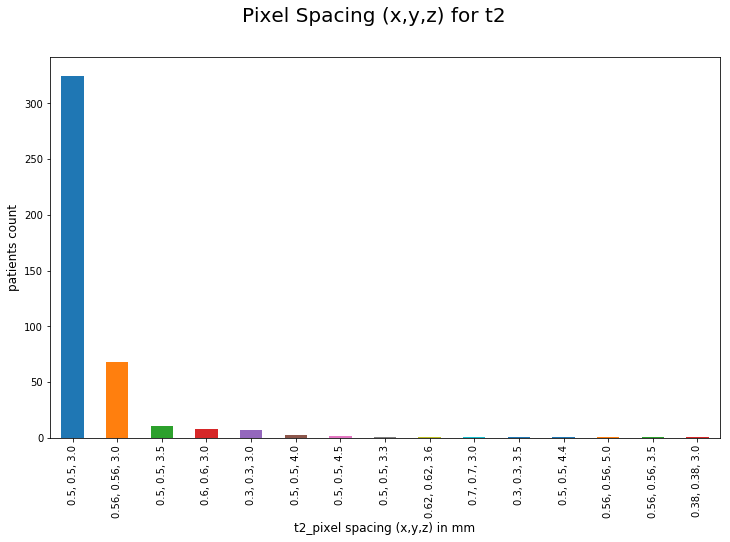

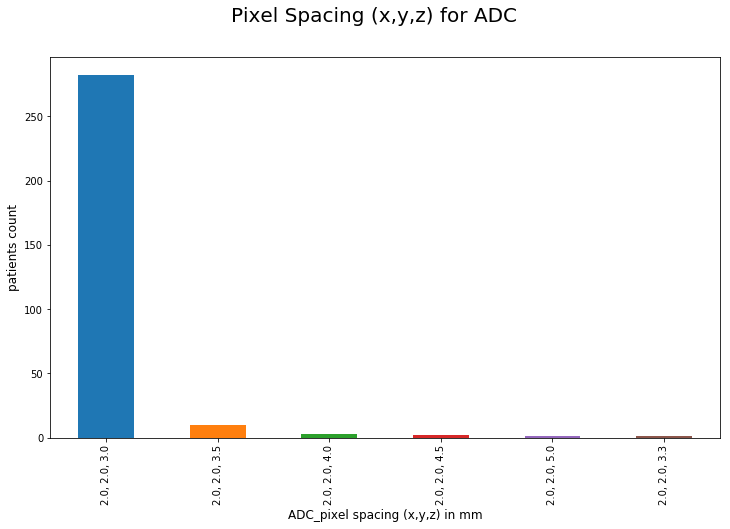

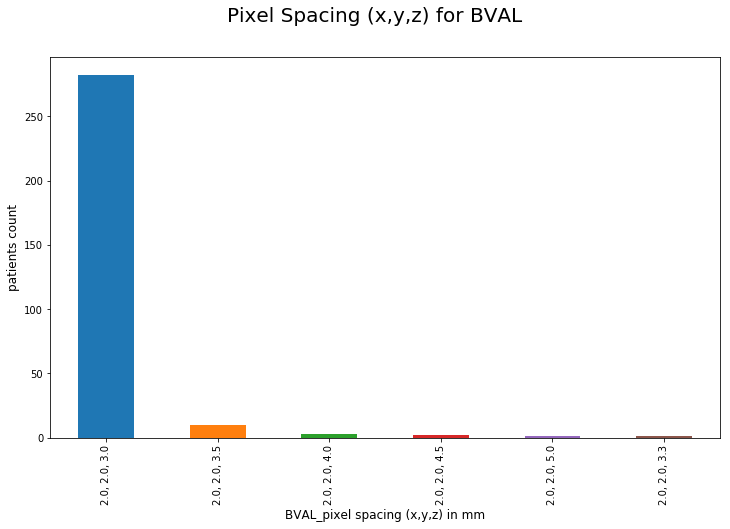

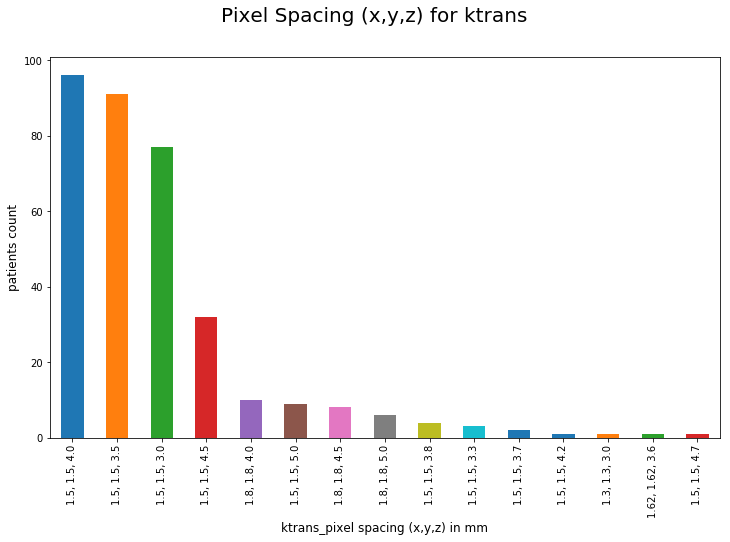

In [4]:
#plotting voxel spacing for each modality 

plot_spacing(t2_folder,t2_tra_images)
plot_spacing(adc_folder,adc_tra_images)
plot_spacing(bval_folder,bval_tra_images)
plot_spacing(ktrans_folder,ktrans_images)

In [6]:
def resample_spacing_dir(folder, matching_images, output_directory):
    
    """
    
    Function resamples voxel spacing of the list of images in the following folder
    
    folder = folder in which the images are
    matching_images = the list with names of the images from the directory for resampling
    output_directory = the directory to which resampled images will be saved
    
    """
    
    #extracting list of fixed images and for threshholding list
    
    fixed_temp = [] #list of image names with the most common voxel spacing value
    
    thresh_list = [] #creating list for voxel spacing
    
    for image in matching_images:
        image_read = sitk.ReadImage(folder+image)
        value=list(image_read.GetSpacing())
        value=[round(i,2) for i in value ]
        thresh_list.append((str(value)).strip('[]'))
    
    temp_df=pd.DataFrame(thresh_list)
    
    thresh_value = temp_df[0].value_counts().keys().tolist() #thresh_list[0] is the most common value of voxel spacing
    
    for image in matching_images:
        image_read = sitk.ReadImage(folder+image)
        value=list(image_read.GetSpacing())
        value=[round(i,2) for i in value]
        if str(value).strip('[]')==thresh_value[0]:
            fixed_temp.append((str(image)).strip('[]'))
            
        else:
            pass
    
    #temporary list with names of files that needed resampling
    
    temp_mov_list = [str(image).strip('[]') for image in matching_images if image not in fixed_temp]
    
    
    
    #resampling part
    fixed_im = sitk.ReadImage(folder+fixed_temp[0])
    for image in temp_mov_list:
        moving=sitk.ReadImage(folder+image)
        
        #getting size for the future resampling
        moving_size_array = np.array(moving.GetSize(),dtype=int)
        moving_spacing_array = np.array(moving.GetSpacing())
        fixed_spacing_array = np.array(fixed_im.GetSpacing())
        
        new_size = moving_size_array*moving_spacing_array/fixed_spacing_array
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(i) for i in new_size]
        new_size = tuple(new_size)
        
            
        resample=sitk.ResampleImageFilter()    
        resample.SetReferenceImage(fixed_im) #selecting reference image. we use first as we need it only for pixel spacing
        
        resample.SetSize(new_size)
        resample.SetOutputOrigin(moving.GetOrigin()) #selecting origing from moving image 
        resample.SetOutputDirection(moving.GetDirection()) #from moving
        resample.SetOutputSpacing(fixed_im.GetSpacing()) #the only parameter from reference fixed image
        resample.SetInterpolator(sitk.sitkBSpline)
                        
        out=resample.Execute(moving)
            
        sitk.WriteImage(out,os.path.join(output_directory, image)) #writing resampled file to new directory
    
    #saving the images that do not need resampling of the voxel spacing 
    
    for item in fixed_temp:
        image_read = sitk.ReadImage(folder+item)
        sitk.WriteImage(image_read,os.path.join(output_directory, item)) #writing files with appropriate voxel sampling to the same directory as resampled files
    
    

In [7]:
"""
Resampling all of the images and saving them into one directory for the further analysis
"""

out_dir = 'C://Image Processing/ProstateX/resampled/'

#t2 resampling
resample_spacing_dir(t2_folder, t2_tra_images, out_dir)

#adc resampling
resample_spacing_dir(adc_folder, adc_tra_images, out_dir)

#bval resampling 
resample_spacing_dir(bval_folder, bval_tra_images, out_dir)

#ktrans
resample_spacing_dir(ktrans_folder, ktrans_images, out_dir)

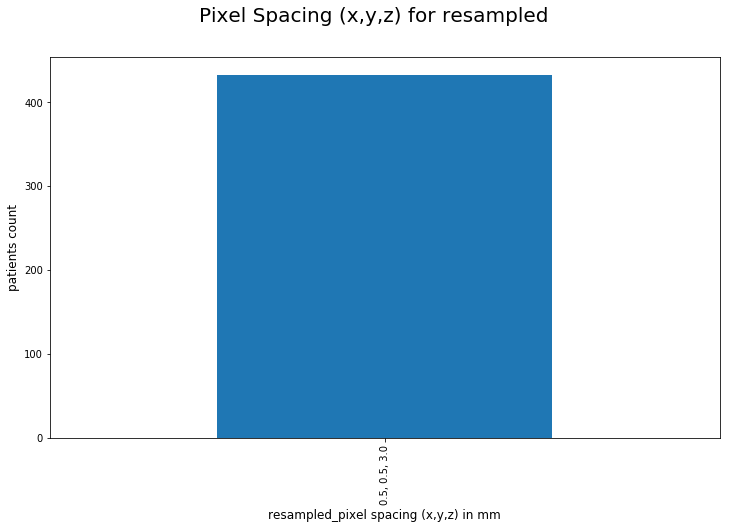

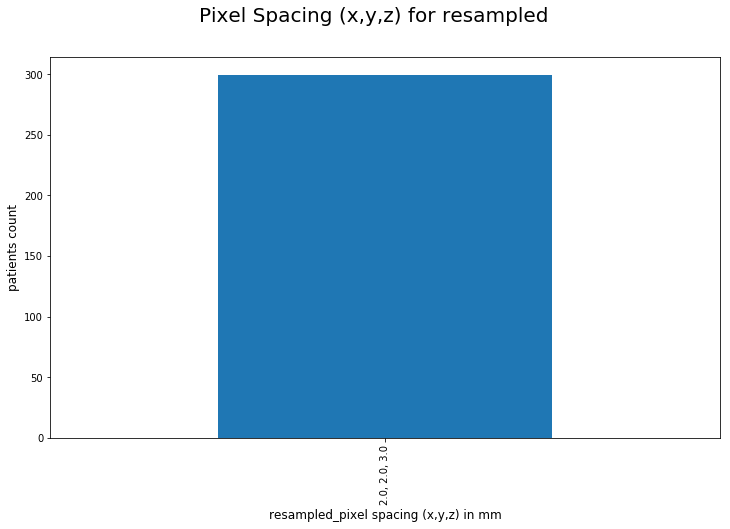

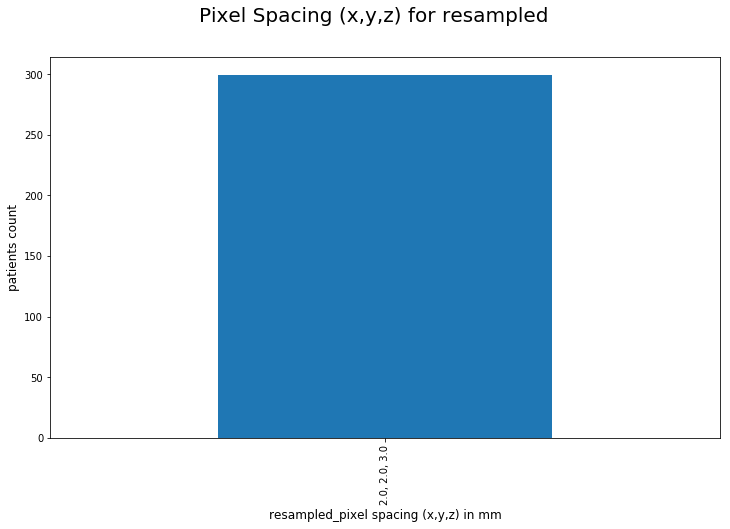

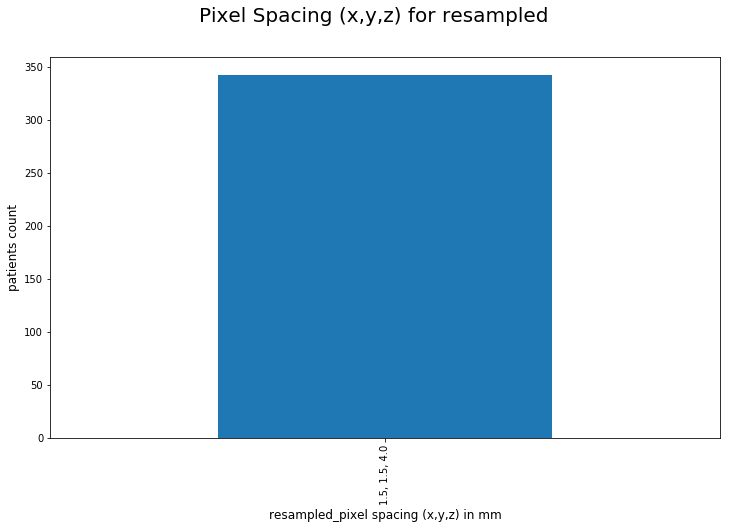

In [8]:
#Checking Voxel Spacing after Resampling for each modality 

#New folder and lists of images 

new_dir = os.listdir('C://Image Processing/ProstateX/resampled/')

#getting lists of corresponding images names in order to apply plotting functions

t2_re = [i for i in new_dir if 't2' in i ]
adc_re= [i for i in new_dir if 'ADC' in i]
bval_re=[i for i in new_dir if 'BVAL' in i]
ktrans_re=[i for i in new_dir if i.endswith('.mhd')] #to read ktrans file we should open only '.mhd' files


#applying plotting for different modalities to check the results of voxel spacing resampling

plot_spacing(out_dir,t2_re)
plot_spacing(out_dir,adc_re)
plot_spacing(out_dir,bval_re)
plot_spacing(out_dir,ktrans_re)


#Nice Results:)
